# 地方競馬（NAR）ベースラインモデル構築

このノートブックでは、これまで作成した特徴量（JIT過去走、人間系統計量、スピード指数）を用いて、着順予測のベースラインモデルを構築します。

## 1. 目的
- 訓練データと検証データの分割（時系列分割）
- データリークがないことの可視化による証明
- LightGBMを用いた着順予測モデルの学習
- 基本的な評価指標（Rank相関、上位的中率等）の確認

In [8]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# プロジェクトのsrcディレクトリをパスに追加
src_path = os.path.abspath(os.path.join(os.getcwd(), '../../src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from nar.loader import NarDataLoader
from nar.features import NarFeatureGenerator

%matplotlib inline
sns.set(font="IPAexGothic", style="whitegrid")

## 2. データのロードと特徴量生成

南関東のデータを読み込み、特徴量を付与します。

In [9]:
loader = NarDataLoader()
# 学習用に少し多めにデータを取得 (2014年〜)
raw_df = loader.load(limit=200000, region='south_kanto')
feature_gen = NarFeatureGenerator(history_windows=[1, 3, 5])
df = feature_gen.generate_features(raw_df)

# 学習対象を絞り込み (着順が確定しているもの)
df = df.dropna(subset=['rank']).copy()
print(f"学習対象レコード数: {len(df)}")

重複データを削除しました: 200000 -> 193051 件


学習対象レコード数: 51175


## 3. 時系列分割とリーク検証

競馬予測において最も重要なのが「未来の情報を現在に使わない」ことです。
ここでは日付ベースで分割し、訓練期間と検証期間が重複していないこと、および特徴量が「過去」のみに基づいていることを可視化します。

Train: 2014-01-01 00:00:00 ~ 2014-12-31 00:00:00 (36626 records)
Test:  2015-01-01 00:00:00 ~ 2015-05-27 00:00:00 (14549 records)


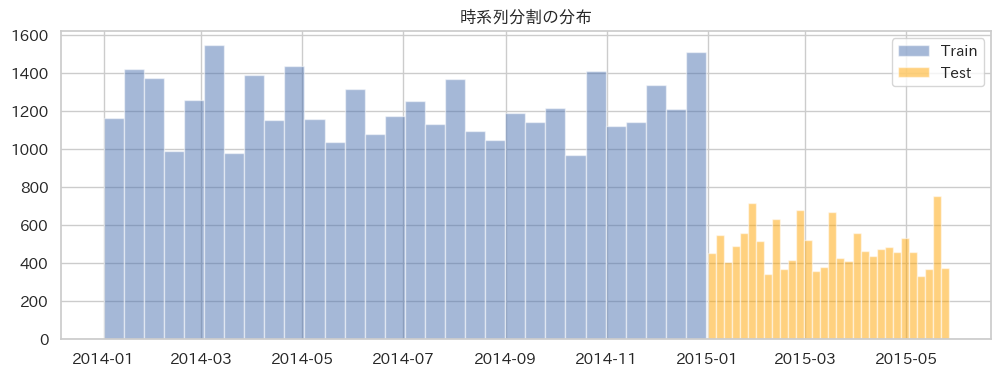

In [10]:
df['date'] = pd.to_datetime(df['date'])
split_date = pd.to_datetime('2015-01-01')
train_df = df[df['date'] < split_date].copy()
test_df = df[df['date'] >= split_date].copy()

print(f"Train: {train_df['date'].min()} ~ {train_df['date'].max()} ({len(train_df)} records)")
print(f"Test:  {test_df['date'].min()} ~ {test_df['date'].max()} ({len(test_df)} records)")

# 可視化: データの期間重複がないことを示す
plt.figure(figsize=(12, 4))
plt.hist(train_df['date'].values, bins=30, alpha=0.5, label='Train')
plt.hist(test_df['date'].values, bins=30, alpha=0.5, label='Test', color='orange')
plt.title("時系列分割の分布")
plt.legend()
plt.show()

### 3.1 特徴量の時間的連続性（リークなしの確認）

特定の馬を例にとり、`horse_prev1_si_avg`（前回の指数）が、実際に前走の `speed_index` と一致しており、かつ今走の値を参照していないことを確認します。

馬ID 2006106115 の履歴確認:


,date,rank,speed_index,horse_prev1_si_avg
737,2014-01-02,8,80.80,NaN
4772,2014-01-10,9,81.00,80.80
6364,2014-01-15,9,81.70,81.00
13359,2014-02-04,10,80.10,81.70
16845,2014-02-14,10,78.80,80.10
24611,2014-03-11,9,77.00,78.80
27298,2014-03-19,10,77.40,77.00
29921,2014-03-26,7,80.40,77.40
35131,2014-04-11,7,79.00,80.40
37449,2014-04-17,9,80.20,79.00


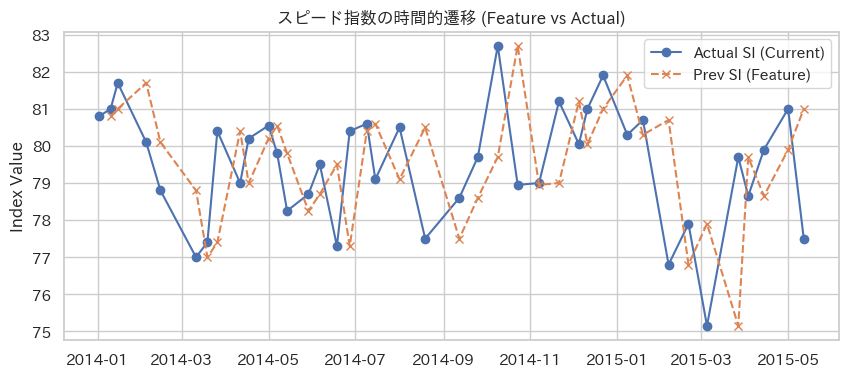

In [11]:
# サンプルとして出走回数が多い馬を1頭ピックアップ
target_horse = train_df['horse_id'].value_counts().index[0]
horse_check = df[df['horse_id'] == target_horse][['date', 'rank', 'speed_index', 'horse_prev1_si_avg']].sort_values('date')

print(f"馬ID {target_horse} の履歴確認:")
display(horse_check)

# 視覚的確認: 特徴量が1走分遅れて（過去から）付与されているか
plt.figure(figsize=(10, 4))
plt.plot(horse_check['date'], horse_check['speed_index'], marker='o', label='Actual SI (Current)')
plt.plot(horse_check['date'], horse_check['horse_prev1_si_avg'], marker='x', linestyle='--', label='Prev SI (Feature)')
plt.title("スピード指数の時間的遷移 (Feature vs Actual)")
plt.ylabel("Index Value")
plt.legend()
plt.show()

## 4. ベースラインモデルの学習 (LightGBM)

目的変数を `rank`（着順）とし、回帰モデルとして学習します。

In [12]:
# 特徴量リストの定義
features = [
    'distance', 'venue', 'state', 'frame_number', 'horse_number', 'weight', 'impost',
    'jockey_win_rate', 'jockey_place_rate', 'trainer_win_rate', 'trainer_place_rate',
    'horse_run_count'
] + [col for col in train_df.columns if 'horse_prev' in col]

# カテゴリ変数の処理
category_cols = ['venue', 'state']
for col in category_cols:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

X_train = train_df[features]
y_train = train_df['rank']
X_test = test_df[features]
y_test = test_df['rank']

print(f"使用する特徴量数: {len(features)}")

# モデルの定義と学習
model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(100)
    ])

使用する特徴量数: 24
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3296
[LightGBM] [Info] Number of data points in the train set: 36626, number of used features: 24
[LightGBM] [Info] Start training from score 6.497734
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 3.2599	valid_0's l2: 10.6269
Early stopping, best iteration is:
[144]	valid_0's rmse: 3.25495	valid_0's l2: 10.5947


LGBMRegressor(learning_rate=0.05, n_estimators=1000, random_state=42)

## 5. 評価

特徴量重要度を確認し、スピード指数や過去走実績がどのように寄与しているかを確認します。

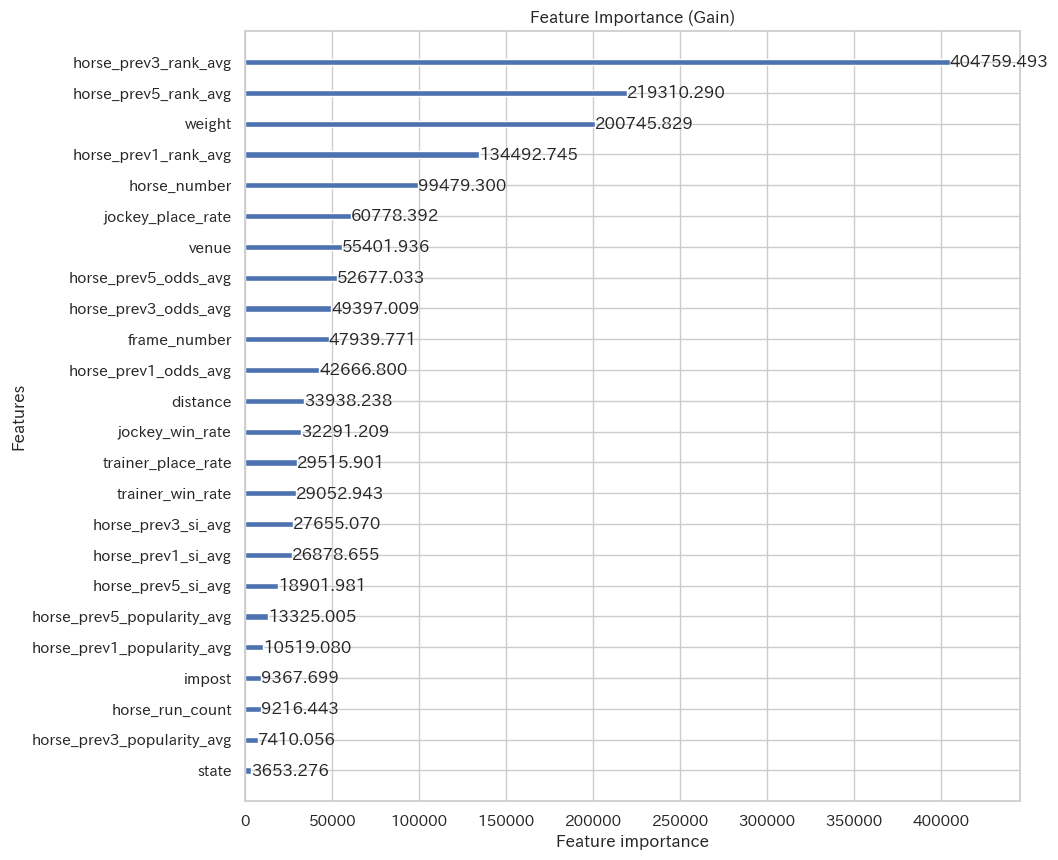

In [13]:
lgb.plot_importance(model, figsize=(10, 10), importance_type='gain')
plt.title("Feature Importance (Gain)")
plt.show()

In [14]:
# 予測値の算出
test_df['pred_rank'] = model.predict(X_test)

# レース内での順序付け (予測値が低い順に1位, 2位...)
test_df['pred_order'] = test_df.groupby('race_id')['pred_rank'].rank()

# 評価: 予測1位が実際に何位だったか
top1_matches = test_df[test_df['pred_order'] == 1]
win_rate = (top1_matches['rank'] == 1).mean()
place_rate = (top1_matches['rank'] <= 3).mean()

print(f"予測1位の勝率: {win_rate:.2%}")
print(f"予測1位の複勝圏内率: {place_rate:.2%}")
print(f"予測1位の平均着順: {top1_matches['rank'].mean():.2f}")

予測1位の勝率: 27.72%
予測1位の複勝圏内率: 60.23%
予測1位の平均着順: 3.60


## 6. 詳細評価

予測性能をより多角的に評価します。
1. 予測スコアと実着順の相関（Spearmanの順位相関係数）
2. 予測順位ごとの的中率（勝率・複勝率）の推移

Spearman順位相関係数: 0.4795 (p-value: 0.0000e+00)


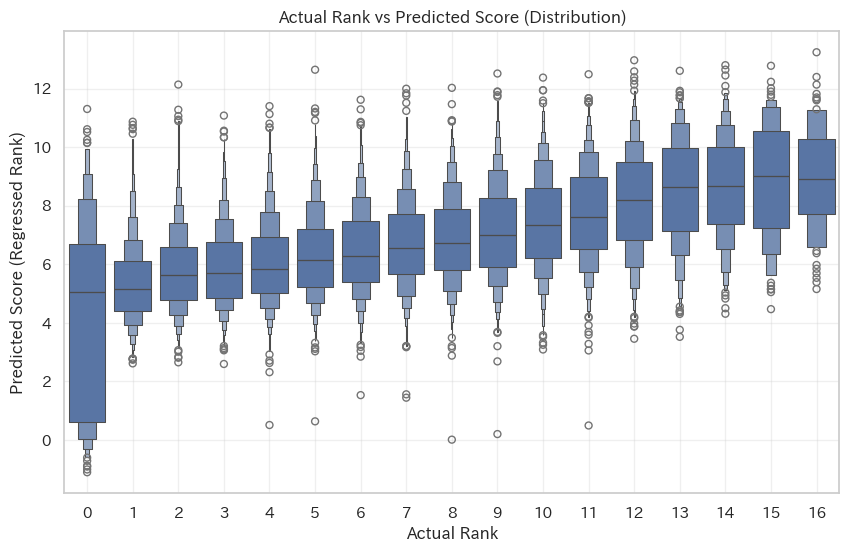

In [15]:
from scipy.stats import spearmanr

# 1. 相関分析
# 'pred_rank' はモデルの回帰出力値（期待着順）
correlation, p_value = spearmanr(test_df['pred_rank'], test_df['rank'])
print(f"Spearman順位相関係数: {correlation:.4f} (p-value: {p_value:.4e})")

# 予測スコア（期待着順）と実着順の分布可視化
plt.figure(figsize=(10, 6))
sns.boxenplot(data=test_df, x='rank', y='pred_rank')
plt.title("Actual Rank vs Predicted Score (Distribution)")
plt.xlabel("Actual Rank")
plt.ylabel("Predicted Score (Regressed Rank)")
plt.grid(True, alpha=0.3)
plt.show()

予測順位別成績:


,win_rate,place_rate,count
predicted_rank_in_race,,,
1.0,0.277228,0.602310,1212
2.0,0.181518,0.470297,1212
3.0,0.130363,0.417492,1212
4.0,0.092409,0.326733,1212
5.0,0.092409,0.305281,1212
6.0,0.066007,0.270627,1212
7.0,0.051367,0.207954,1207
8.0,0.031014,0.176865,1193
9.0,0.029437,0.133333,1155


/tmp/ipykernel_3905740/1995317240.py:19: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  sns.barplot(x=eval_by_rank.index[:10].astype(int), y=eval_by_rank['win_rate'][:10], palette='viridis')
/tmp/ipykernel_3905740/1995317240.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eval_by_rank.index[:10].astype(int), y=eval_by_rank['win_rate'][:10], palette='viridis')
/tmp/ipykernel_3905740/1995317240.py:26: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  sns.barplot(x=eval_by_rank.index[:10].astype(int), y=eval_by_r

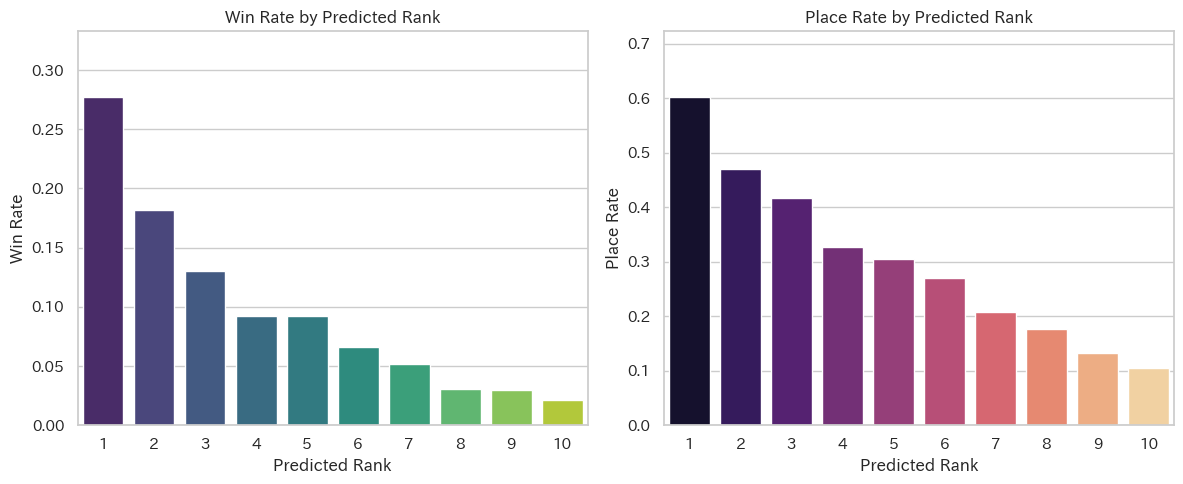

In [16]:
# 2. 予測順位ごとの成績集計
# 各レース内での予測スコア順位を割り当て（小さいほど高く評価）
test_df['predicted_rank_in_race'] = test_df.groupby('race_id')['pred_rank'].rank(method='min')

# 予測順位ごとの勝率・複勝率を計算
eval_by_rank = test_df.groupby('predicted_rank_in_race').agg({
    'rank': [lambda x: (x == 1).mean(), lambda x: (x <= 3).mean(), 'count']
})
eval_by_rank.columns = ['win_rate', 'place_rate', 'count']
eval_by_rank = eval_by_rank.query('count >= 10') # サンプル数が少ない順位を除外

print("予測順位別成績:")
display(eval_by_rank.head(10))

# 可視化
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=eval_by_rank.index[:10].astype(int), y=eval_by_rank['win_rate'][:10], palette='viridis')
plt.title("Win Rate by Predicted Rank")
plt.xlabel("Predicted Rank")
plt.ylabel("Win Rate")
plt.ylim(0, max(eval_by_rank['win_rate']) * 1.2)

plt.subplot(1, 2, 2)
sns.barplot(x=eval_by_rank.index[:10].astype(int), y=eval_by_rank['place_rate'][:10], palette='magma')
plt.title("Place Rate by Predicted Rank")
plt.xlabel("Predicted Rank")
plt.ylabel("Place Rate")
plt.ylim(0, max(eval_by_rank['place_rate']) * 1.2)

plt.tight_layout()
plt.show()